# Gaussian Process Regression with Elliptical Slice Sampling

[Elliptical slice sampling](https://arxiv.org/abs/1001.0175) is a variant of slice sampling that allows sampling from distributions with multivariate Gaussian prior and arbitrary likelihood. It is generally about as fast as regular slice sampling, mixes well even when the prior covariance might otherwise induce a strong dependence between samples, and does not depend on any tuning parameters. It finds one natural application in working with Gaussian processes, in which one often uses a multivariate Gaussian prior to impose a covariance structure on some latent function.

This notebook provides a simple example of how to use PyMC3's elliptical slice sampler to perform Gaussian process regression.

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from itertools import cycle

sns.set(style='whitegrid', palette='deep', color_codes=True)

%matplotlib inline

### Generate some example data

We generate some noisy data from a sine function sampled at 30 random points between zero and one and predict the function's value at 50 points between zero and one.

In [2]:
np.random.seed(1)

# Number of training points
n = 30
X0 = np.sort(np.random.rand(n))[:, None]

# Number of points at which to predict
m = 50
X = np.linspace(0, 1, m)[:, None]

noise_true = 0.5

def f(x):
    """True function."""
    return np.sin(10 * x).flatten()

# Observed data
f_true = f(X0)
f_obs = f_true + np.random.normal(loc=0, scale=noise_true**0.5, size=f_true.shape[0])

The posterior is analytically tractable so we can compute the posterior mean explicitly given a parameter setting. Rather than computing the inverse of the covariance matrix `K`, we use the numerically stable calculation described Algorithm 2.1 in the book "Gaussian Processes for Machine Learning" (2006) by Rasmussen and Williams, which is [available online for free](http://www.gaussianprocess.org/gpml/).

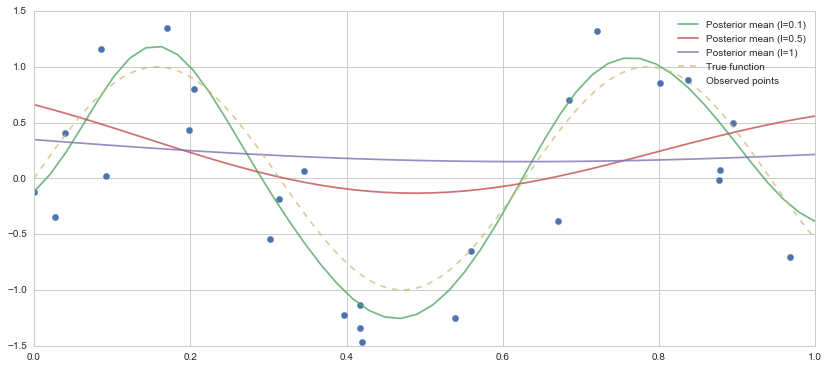

In [3]:
fig, ax = plt.subplots(figsize=(14, 6));
colors = cycle(sns.color_palette('deep'))
ax.scatter(X0, f_obs,  s=40, color=next(colors), label='Observed points');
ax.plot(np.linspace(0, 1, 100), np.sin(10 * np.linspace(0, 1, 100)), linestyle='--', alpha=0.7,
        color=next(colors), label='True function');

# We could vary the function scale, noise, and length scale, but for simplicity we just vary the length scale
for lengthscale in [0.1, 0.5, 1]:
    # Compute covariance matrices
    cov = pm.gp.cov.ExpQuad(1, lengthscale)
    K_noise = cov.K(X0).eval() + noise_true * np.eye(n)
    K_s = cov.K(X0, X).eval()

    # Analytically compute posterior mean
    L = np.linalg.cholesky(K_noise)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, f_obs))
    post_mean = np.dot(K_s.T, alpha)
    
    ax.plot(X, post_mean, color=next(colors), alpha=0.8, label='Posterior mean (l={})'.format(lengthscale));
    
ax.set_xlim(0, 1);
ax.set_ylim(-1.5, 1.5);
ax.legend();

### Sample from the posterior

We sample from the model and fit three parameters: the length scale of the kernel, the noise in the observations, and the vertical scale of the function. We put relatively informative `HalfCauchy(0.1)` priors on all three because with observed function falling between $\pm1.5$, it's unlikely that a good setting for any of the parameters would be very large. For example, the above plot shows a case in which a length scale of one results a nearly flat posterior.

In [4]:
with pm.Model() as model:
    # Length scale of the covariance function
    lengthscale = pm.HalfCauchy('lengthscale', 0.1)
    
    # Variance of the normally distributed noise in the observed values
    noise_obs = pm.HalfCauchy('noise_obs', 0.1)
    
    # Y-axis function scale
    f_scale = pm.HalfCauchy('f_scale', 0.1)
    
    # Covariance matrices
    cov = pm.gp.cov.ExpQuad(1, lengthscale)
    K_sample = cov.K(X0)
    K_s = cov.K(X0, X)
    K_noise = K_sample + noise_obs * np.eye(n)
    
    # Add very slight perturbation to the covariance matrix diagonal to improve numerical stability
    K_stable = K_sample + 1e-10 * np.eye(n)

    # Prior and likelihood for elliptical slice sampling
    f_sample = pm.MvNormal('f_sample', mu=np.zeros(n), cov=K_stable, shape=n)
    y = pm.MvNormal('y', observed=f_obs, mu=f_scale * f_sample, cov=noise_obs * np.eye(n), shape=n) 
    ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K_stable)
    
    # Predict function values at the test points
    L = pm.Deterministic('L', tt.slinalg.cholesky(K_noise))
    f_pred = pm.Deterministic('f_pred', tt.dot(K_s.T, tt.slinalg.solve(L.T, tt.slinalg.solve(L, f_sample))))
    
    # Use slice sampling for the other variables
    slice_step = pm.Slice(vars=[lengthscale, noise_obs, f_scale])
    trace = pm.sample(20000, step=[ess_step, slice_step], progressbar=False, random_seed=1)

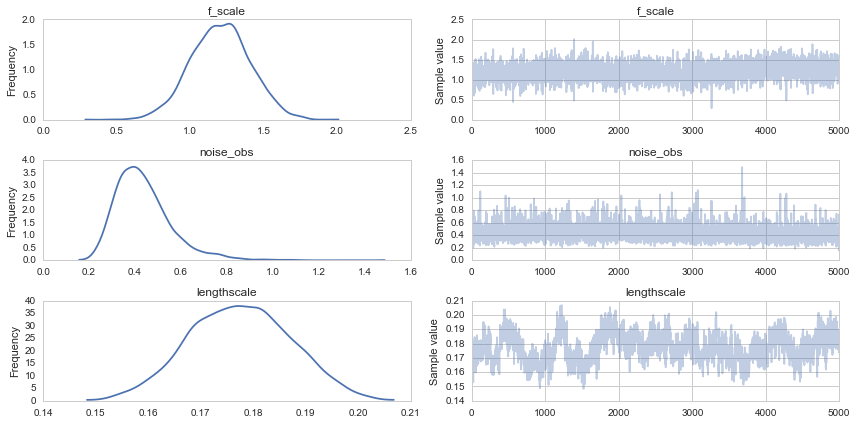

In [5]:
pm.traceplot(trace[15000:], ['f_scale', 'noise_obs', 'lengthscale']);

The traceplot shows good mixing with the possible exception of the length scale parameter. The samples from the posterior below show that the posterior fits the data reasonably well. As expected, the samples roughly approximates the true function but are more conservative, reflecting the uncertainty inherent in the noisy observations.

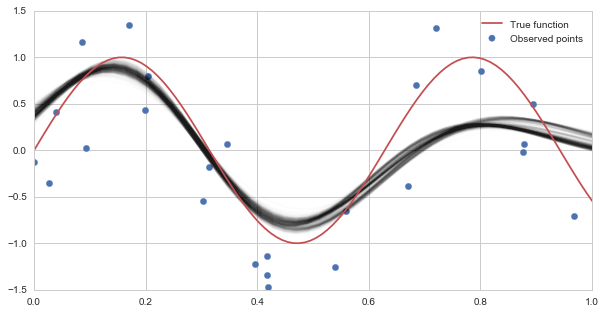

In [6]:
fig, ax = plt.subplots(figsize=(10, 5));
for idx in np.random.randint(18000, 20000, 500):
    ax.plot(X, trace['f_pred'][idx],  alpha=0.01, color='k')
ax.scatter(X0, f_obs, s=40, color='b', label='Observed points');
ax.plot(np.linspace(0, 1, 100), f(np.linspace(0, 1, 100)), color='r', label='True function')
ax.legend();
ax.set_xlim(0, 1);
ax.set_ylim(-1.5, 1.5);